In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from dataloader import make_dataloaders
from model import ResNet
from model import ConvNet
from model import SE_ResNet
import time
import torch.nn.functional as F

In [3]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [3]:
model_list = os.listdir("../Models")
print(model_list)

['10-06-20:1620_ConvNet_lr=0.01_droprate=0.6_blocks=0_features=64_height=256', '11-06-20:0004_ConvNet_lr=0.01_droprate=0.6_blocks=0_features=64_height=128', '10-06-20:2239_ConvNet_lr=0.01_droprate=0.6_blocks=0_features=64_height=256', '11-06-20:0134_ConvNet_lr=0.01_droprate=0.6_blocks=0_features=64_height=128', '10-06-20:1635_ConvNet_lr=0.01_droprate=0.6_blocks=0_features=64_height=128']


In [5]:
#Define hyperparameters and model
batch_size = 128
model_choice = "ConvNet" #"SE_ResNet" "ResNet" "ConvNet"
n_features = 64
height = 128
width = 256
num_blocks = 0
r = 16
    
train_loader,test_loader = make_dataloaders(height, width, batch_size,transform=True,intensity=True,intensity_type="channel",weighted=False)

In [5]:
#initialize model and sent to device
if model_choice == "SE_ResNet":
    model = SE_ResNet(n_in=7, n_features=n_features, height=height, width=width, droprate=droprate, num_blocks=num_blocks, r=r).float()
    model.to(device)
    print("SE_ResNet initialized")
    
elif model_choice == "ResNet":
    model = ResNet(n_in=7, n_features=n_features, height=height, width=width, droprate=droprate, num_blocks=num_blocks).float()
    model.to(device)
    print("ResNet initialized")
    
elif model_choice == "ConvNet":
    model = ConvNet(n_in=7, n_features=n_features, height=height, width=width, droprate=droprate).float()
    model.to(device)
    print("ConvNet initialized")

else:
    sys.exit("The chosen model isn't valid")

ConvNet initialized


In [6]:
model.load_state_dict(torch.load("../Models/{}".format(model_list[1]),map_location=device))
model.eval()

ConvNet(
  (conv1): Sequential(
    (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.6, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.6, inplace=False)
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.6, inplace=False)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): BatchNorm2d(256, eps=1e-05, mo

In [7]:
pred_ = []
target_ = []
output_ = []

for data, target, scaler in test_loader:
    data, scaler = data.to(device), scaler.to(device)
    with torch.no_grad():
        output = F.softmax(model(data, scaler),dim=1)
    predicted = output.argmax(1).cpu()
    
    pred_.append(predicted)
    output_.append(output)
    target_.append(target)
    
    del data,target,scaler,output,predicted

In [8]:
pred_ = torch.cat(pred_)
target_ = torch.cat(target_)
output_ = torch.cat(output_)

In [13]:
test_loader.dataset.name_to_label

{'Barley': 0, 'Broken': 1, 'Oat': 2, 'Rye': 3, 'Wheat': 4}

In [9]:
wrong = pred_ != target_
print(pred_[wrong])
print(target_[wrong])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
        0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 1, 3,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 3, 3, 0, 0, 0, 3, 1, 0, 0, 0, 0, 1, 0, 3, 0, 1, 0, 0, 0, 3, 3, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 3, 3, 0, 3, 0, 0, 0,
        0, 3, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 3, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,

In [10]:
print((pred_[wrong] == 0).sum())
print((pred_[wrong] == 1).sum())
print((pred_[wrong] == 2).sum())
print((pred_[wrong] == 3).sum())
print((pred_[wrong] == 4).sum())

tensor(258)
tensor(237)
tensor(0)
tensor(34)
tensor(0)


In [10]:
data, target, scaler = next(iter(train_loader))

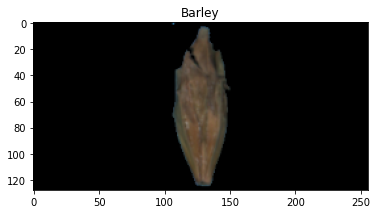

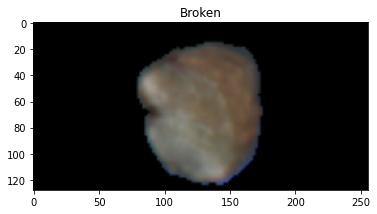

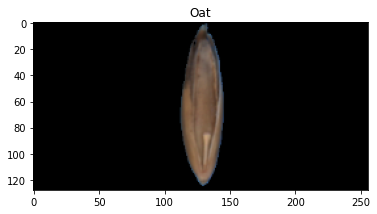

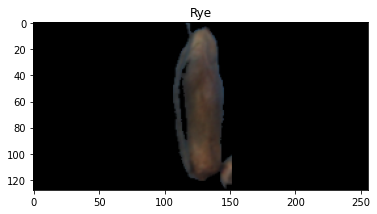

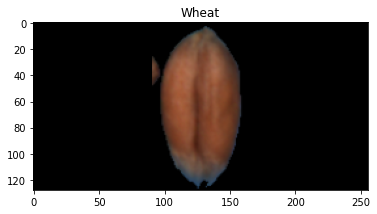

In [11]:
plt.imshow(np.moveaxis(data[np.where(target.numpy()==0)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Barley")
plt.show()
plt.imshow(np.moveaxis(data[np.where(target.numpy()==1)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Broken")
plt.show()
plt.imshow(np.moveaxis(data[np.where(target.numpy()==2)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Oat")
plt.show()
plt.imshow(np.moveaxis(data[np.where(target.numpy()==3)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Rye")
plt.show()
plt.imshow(np.moveaxis(data[np.where(target.numpy()==4)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Wheat")
plt.show()

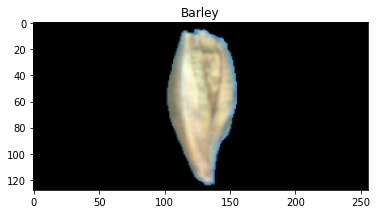

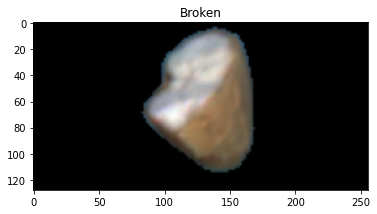

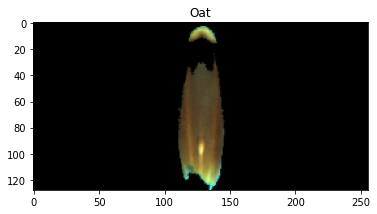

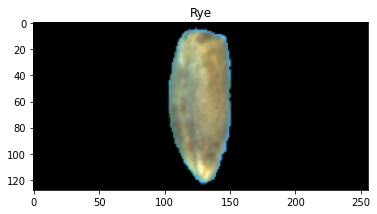

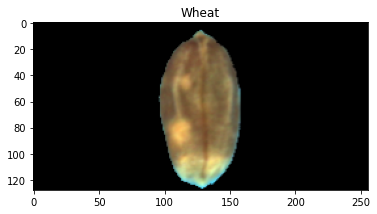

In [7]:
plt.imshow(np.moveaxis(data[np.where(target.numpy()==0)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Barley")
plt.show()
plt.imshow(np.moveaxis(data[np.where(target.numpy()==1)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Broken")
plt.show()
plt.imshow(np.moveaxis(data[np.where(target.numpy()==2)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Oat")
plt.show()
plt.imshow(np.moveaxis(data[np.where(target.numpy()==3)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Rye")
plt.show()
plt.imshow(np.moveaxis(data[np.where(target.numpy()==4)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Wheat")
plt.show()

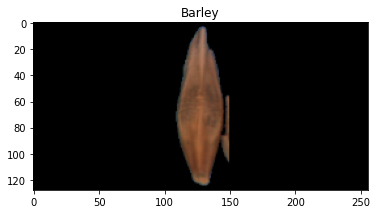

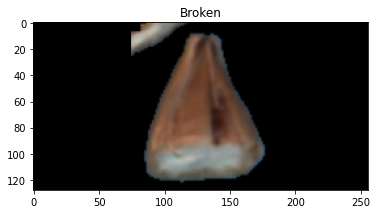

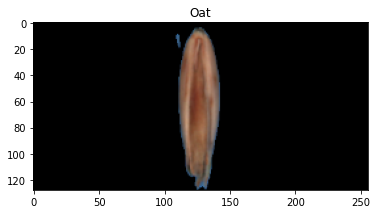

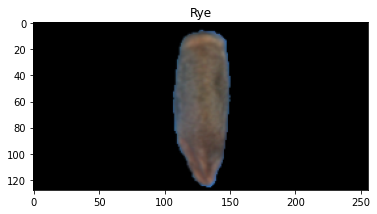

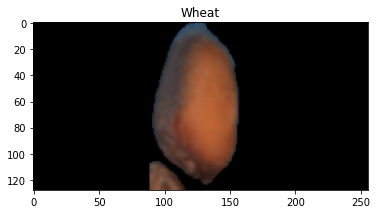

In [4]:
plt.imshow(np.moveaxis(data[np.where(target.numpy()==0)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Barley")
plt.show()
plt.imshow(np.moveaxis(data[np.where(target.numpy()==1)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Broken")
plt.show()
plt.imshow(np.moveaxis(data[np.where(target.numpy()==2)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Oat")
plt.show()
plt.imshow(np.moveaxis(data[np.where(target.numpy()==3)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Rye")
plt.show()
plt.imshow(np.moveaxis(data[np.where(target.numpy()==4)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Wheat")
plt.show()